In [1]:
import logging
import pandas as pd
from sqlalchemy import create_engine, text
import requests, os, pickle
from dotenv import load_dotenv
load_dotenv()

################################################################################################################################
################################################################################################################################
###################################    LOGGER            ###################################################################
################################################################################################################################
################################################################################################################################

# Setup the logger to log in console and file.
logger = logging.getLogger("my_logger")  # Name your logger
if logger.hasHandlers(): logger.handlers.clear()  # Remove all existing handlers
logger.setLevel(logging.DEBUG)  # Set the minimum log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)  # Set the level for console output
file_handler = logging.FileHandler("app.log")  # Log to a file named 'app.log'
file_handler.setLevel(logging.ERROR)  # Log only ERROR or higher to the file
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)
logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Example usage of the logger
'''
try:
    # Simulate an error
    1 / 0
except ZeroDivisionError as e:
    logger.error("An error occurred", exc_info=True)  # Log with stack trace
'''

################################################################################################################################
################################################################################################################################
###################################    PARAMETER            ###################################################################
################################################################################################################################
################################################################################################################################

# Parameter
## General
db_user = 'myuser'
db_password = 'mypassword'
db_host = 'localhost'
db_port = '7005'
db_name = 'finance_db'

## DB
schema = "finance_data"
table = "CLOSING_PRICE_DAILY"
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
with engine.begin() as connection: connection.execute(text(f"CREATE SCHEMA IF NOT EXISTS {schema};"))

################################################################################################################################
################################################################################################################################
###################################    FUNCTIONS            ###################################################################
################################################################################################################################
################################################################################################################################

def get_daily_closing_price_for_stock(symbol, api_key= os.getenv("AOI_KEY__ALPHA_VANTAGE")):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}'
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        return response  # Return parsed JSON response
    except Exception as e:
        logger.error(f"An error occurred: {e}")
        return None


def get_df_from_response(response, symbol):
    data = response.json()
    if 'Time Series (Daily)' in data:
        df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index', dtype=float)
        df = df.rename(columns={
            '1. open': 'Open',
            '2. high': 'High',
            '3. low': 'Low',
            '4. close': 'Close',
            '5. volume': 'Volume'
        })
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)

        df.index.name = 'Date'  # Set index name
        df.reset_index(inplace=True)  # Reset index and bring 'Date' into a column

        # Ensure the Date column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        df["Symbol"] = symbol
        return df
    else:
        logger.info(f"Error fetching data for {symbol}: {data.get('Note', 'Unknown error')}")
        return pd.DataFrame()

def delete_df_from_db(df, symbol_to_filter, engine = engine):
    dates_to_delete = list(df["Date"])  # Ensure dates are compatible with the database format
    dates_to_delete = [str(date) for date in dates_to_delete]  # Convert dates to strings if needed

    query = f'''
        DELETE FROM "{schema}"."{table}"
        WHERE "Symbol" = :symbol
    '''

    if dates_to_delete:
        query += ' AND "Date" IN :dates'

    # Execute the query
    with engine.begin() as connection:
        params = {"symbol": symbol_to_filter}
        if dates_to_delete:
            params["dates"] = tuple(dates_to_delete)

        delete_query = text(query)
        result = connection.execute(delete_query, params)
        logger.info(f"{result.rowcount} rows deleted.")

    logger.info(f"DF VALUES DELETED FROM DB")

def write_df_to_db(df, symbol, engine = engine):
    delete_df_from_db(df, symbol)
    try:
        df.to_sql(table, engine, if_exists='append', index=False, schema=schema)
    except Exception as e:
        # Log the error with details
        logging.error(f"Failed to write data to table {schema}.{table}: {e}")

    logger.info("Data written to PostgreSQL successfully!")

# GET DATA. This only needs to run once. With free version, this can only run about 25 times a day due to rate limit.
def get_source_data(list_symbols = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "GOOG", "META", "TSLA", "BRK.B", "AVGO"], load_from_pickle = False):
    if load_from_pickle:
        logger.info("LOAD DATA FROM LOCAL")
        with open("j_response.pkl", "rb") as file:
            return pickle.load(file)
    logger.info("LOAD DATA VIA API")
    j_response = {}
    for symbol in list_symbols:
        j_response[symbol] = get_daily_closing_price_for_stock(symbol)

    return j_response

j_response = get_source_data(load_from_pickle=True)

2024-11-21 16:02:24,126 - my_logger - INFO - LOAD DATA FROM LOCAL


In [2]:
# Write the dictionary to a pickle file. Ensures we have the source data.
#with open("j_response.pkl", "wb") as file: pickle.dump(j_response, file)

In [3]:
j_df = {}
for symbol, response in j_response.items():
    df = get_df_from_response(response, symbol)
    write_df_to_db(df, symbol)
    j_df[symbol] = df.copy()

2024-11-21 16:02:24,147 - my_logger - INFO - 100 rows deleted.
2024-11-21 16:02:24,148 - my_logger - INFO - DF VALUES DELETED FROM DB
2024-11-21 16:02:24,170 - my_logger - INFO - Data written to PostgreSQL successfully!
2024-11-21 16:02:24,174 - my_logger - INFO - 100 rows deleted.
2024-11-21 16:02:24,175 - my_logger - INFO - DF VALUES DELETED FROM DB
2024-11-21 16:02:24,183 - my_logger - INFO - Data written to PostgreSQL successfully!
2024-11-21 16:02:24,187 - my_logger - INFO - 100 rows deleted.
2024-11-21 16:02:24,189 - my_logger - INFO - DF VALUES DELETED FROM DB
2024-11-21 16:02:24,196 - my_logger - INFO - Data written to PostgreSQL successfully!
2024-11-21 16:02:24,200 - my_logger - INFO - 100 rows deleted.
2024-11-21 16:02:24,200 - my_logger - INFO - DF VALUES DELETED FROM DB
2024-11-21 16:02:24,206 - my_logger - INFO - Data written to PostgreSQL successfully!
2024-11-21 16:02:24,208 - my_logger - INFO - 100 rows deleted.
2024-11-21 16:02:24,209 - my_logger - INFO - DF VALUES DE

In [4]:
#delete_df_from_db(df)

All stuff before was done to get data. Now we evaluate them,

In [5]:
# query db
query = f'SELECT * FROM "{schema}"."{table}";'
with engine.connect() as connection: df = pd.read_sql(query, connection)
df

,Date,Open,High,Low,Close,Volume,Symbol
0,2024-07-02,216.15,220.3800,215.1000,220.27,58046178.0,AAPL
1,2024-07-03,220.00,221.5500,219.0300,221.55,37369801.0,AAPL
2,2024-07-05,221.65,226.4500,221.6500,226.34,60412408.0,AAPL
3,2024-07-08,227.09,227.8500,223.2500,227.82,59085861.0,AAPL
4,2024-07-09,227.93,229.4000,226.3721,228.68,48169822.0,AAPL
...,...,...,...,...,...,...,...
995,2024-11-14,174.77,175.5700,169.8700,170.38,20638855.0,AVGO
996,2024-11-15,168.47,169.1350,163.4300,164.84,20836160.0,AVGO
997,2024-11-18,165.66,166.3463,162.2200,165.67,17870329.0,AVGO
998,2024-11-19,166.66,166.8000,164.3100,165.35,18003401.0,AVGO


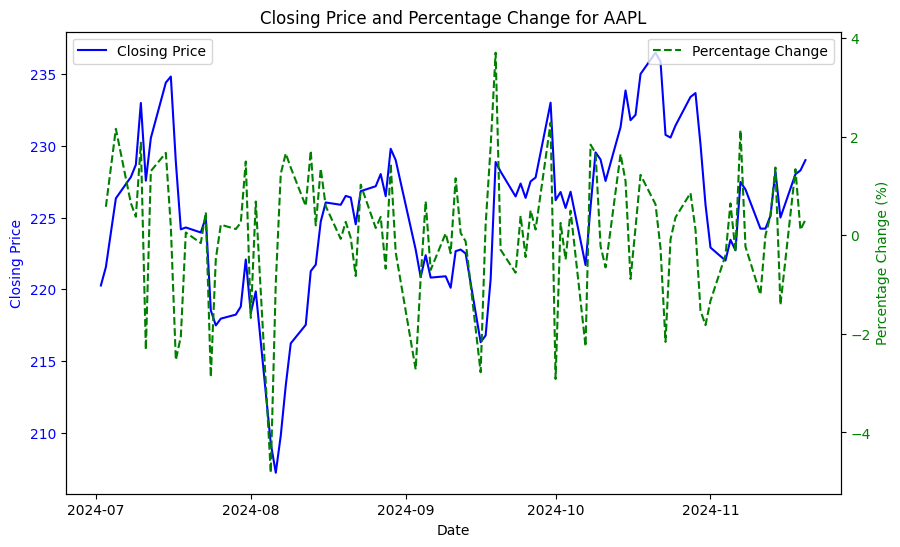

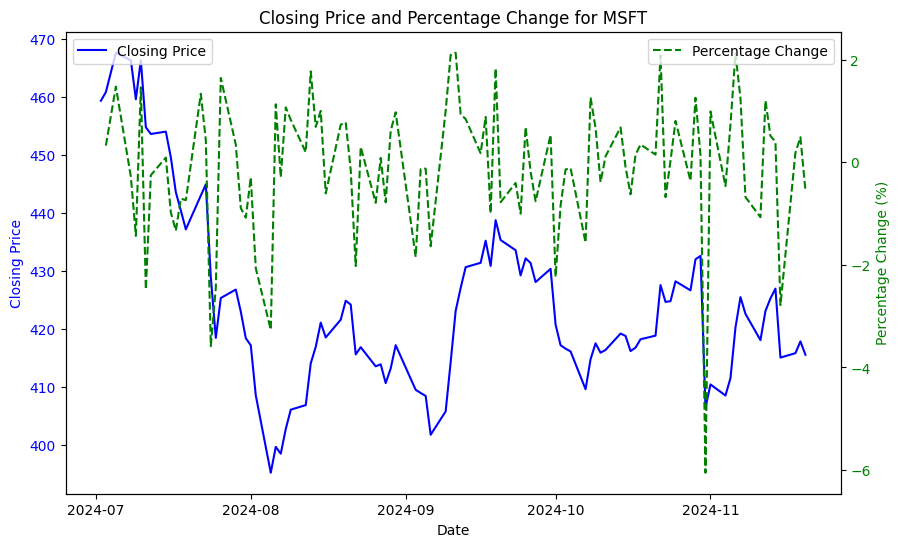

In [6]:
import matplotlib.pyplot as plt

# Define the list of symbols for which to plot
symbols = ['AAPL', 'MSFT']

df['Percent_Change'] = df.groupby('Symbol')['Close'].pct_change() * 100


# Filter the DataFrame for the selected symbols
filtered_df = df[df['Symbol'].isin(symbols)]

# Plot for each symbol
for symbol in symbols:
    symbol_data = filtered_df[filtered_df['Symbol'] == symbol]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot closing prices on the left y-axis
    ax1.set_title(f"Closing Price and Percentage Change for {symbol}")
    ax1.plot(symbol_data['Date'], symbol_data['Close'], label='Closing Price', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Closing Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for the percentage change
    ax2 = ax1.twinx()
    ax2.plot(symbol_data['Date'], symbol_data['Percent_Change'], label='Percentage Change', color='green', linestyle='--')
    ax2.set_ylabel('Percentage Change (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()


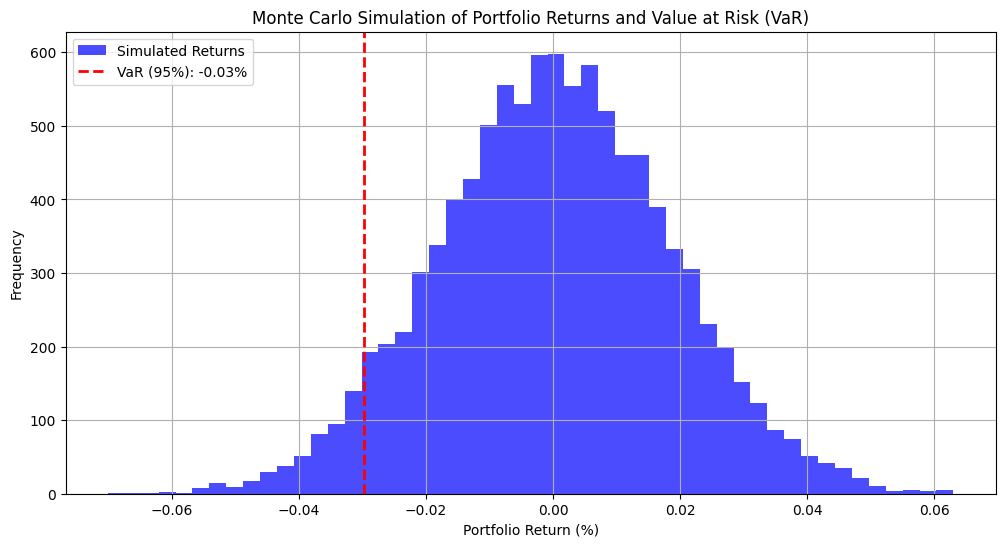

Portfolio VaR at 95% confidence level: -0.03%


In [7]:
import numpy as np

# query db
query = f'SELECT * FROM "{schema}"."{table}";'
with engine.connect() as connection: df = pd.read_sql(query, connection)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Calculate daily returns for each symbol
df['Percent_Change'] = df.groupby('Symbol')['Close'].pct_change() * 100

# Pivot table to create a matrix of symbols with daily percent changes
returns_df = df.pivot(index='Date', columns='Symbol', values='Percent_Change').dropna()

# Portfolio weights (example: equal weights for all symbols)
symbols = returns_df.columns
weights = np.array([1 / len(symbols)] * len(symbols))  # Equal weights

# Calculate portfolio returns
portfolio_returns = returns_df.dot(weights / 100)  # Normalize weights for percentages

# Monte Carlo Simulation
num_simulations = 10000
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()

simulated_returns = np.random.normal(mean, std_dev, num_simulations)
var_95 = np.percentile(simulated_returns, 5)  # 5th percentile for 95% confidence level

# Visualization
plt.figure(figsize=(12, 6))

# Plot histogram of simulated returns
plt.hist(simulated_returns, bins=50, alpha=0.7, color='blue', label='Simulated Returns')

# Add VaR line
plt.axvline(var_95, color='red', linestyle='--', linewidth=2, label=f'VaR (95%): {var_95:.2f}%')

# Add title and labels
plt.title('Monte Carlo Simulation of Portfolio Returns and Value at Risk (VaR)')
plt.xlabel('Portfolio Return (%)')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.show()

# Display VaR
print(f"Portfolio VaR at 95% confidence level: {var_95:.2f}%")
